# $\Phi$-SO demo

## Packages import

In [1]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [2]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [3]:
torch.cuda.is_available()

False

## Test case

#### Data points

In [4]:
data_size = int(1e3)

In [5]:
# Data points
t  = np.random.uniform(np.pi, 10*np.pi, data_size)
X_array = np.stack((t,), axis=0)
f      = 0.784
alpha0 = 1/9.89
phi    = 0.997
y_array = np.exp(-t*alpha0)*np.cos(f*t + phi)

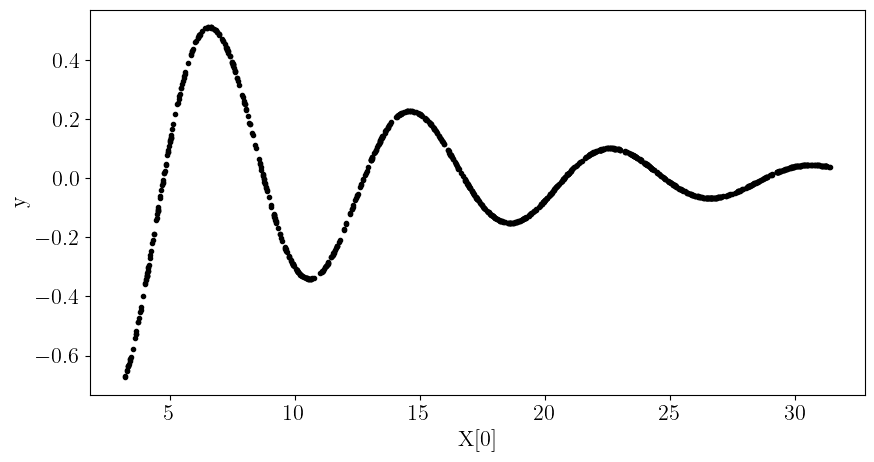

In [6]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

#### Sending data to device

In [7]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array( 1.   )).to(DEVICE)

## Run config

### Library config

In [8]:
# [length, mass, time]
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"t" : 0         ,},
                "input_var_units"      : {"t" : [0, 0, 1] ,},
                "input_var_complexity" : {"t" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"f"               , "alpha0"               , "phi"               , },
                "free_constants_init_val"   : {"f" : 1.          , "alpha0" : 1/10.       , "phi" : 1.          , },
                "free_constants_units"      : {"f" : [0, 0, -1]  , "alpha0" : [0, 0, -1]  , "phi" : [0, 0, 0]   , },
                "free_constants_complexity" : {"f" : 1.          , "alpha0" : 1.          , "phi" : 1.          , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, 0, 0],
                  "superparent_name"  : "F",
                }


### Learning config

In [9]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                 "parallel_mode" : True,
                 "n_cpus"        : None,
                }

In [10]:
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [11]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [12]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-6,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [13]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [14]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [15]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 10,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [16]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

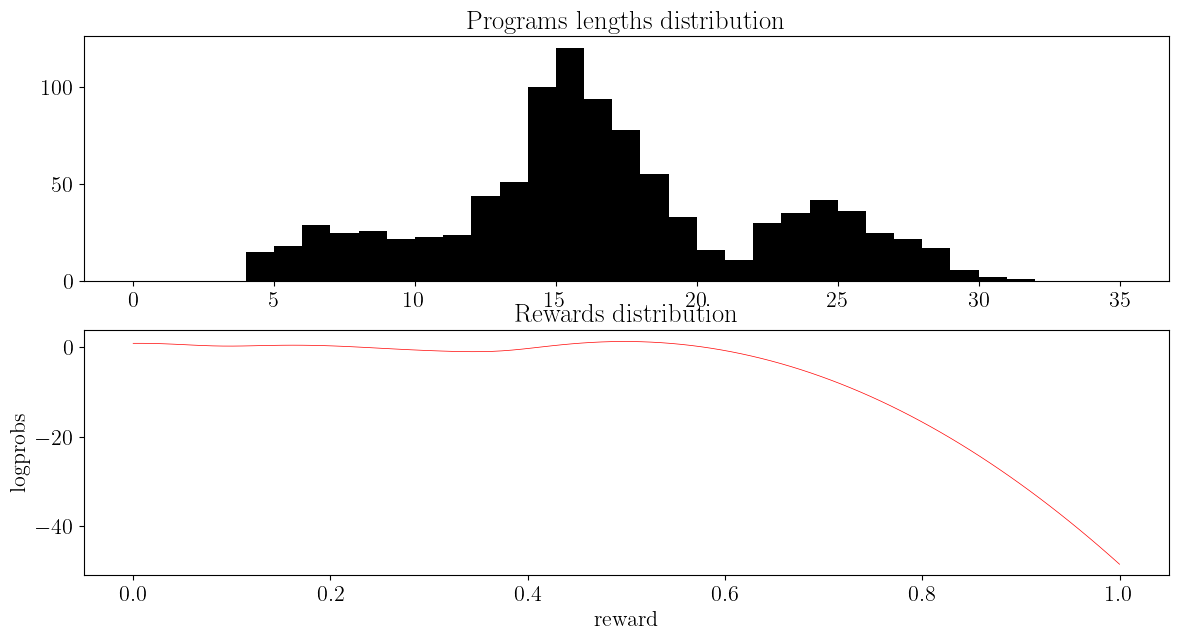

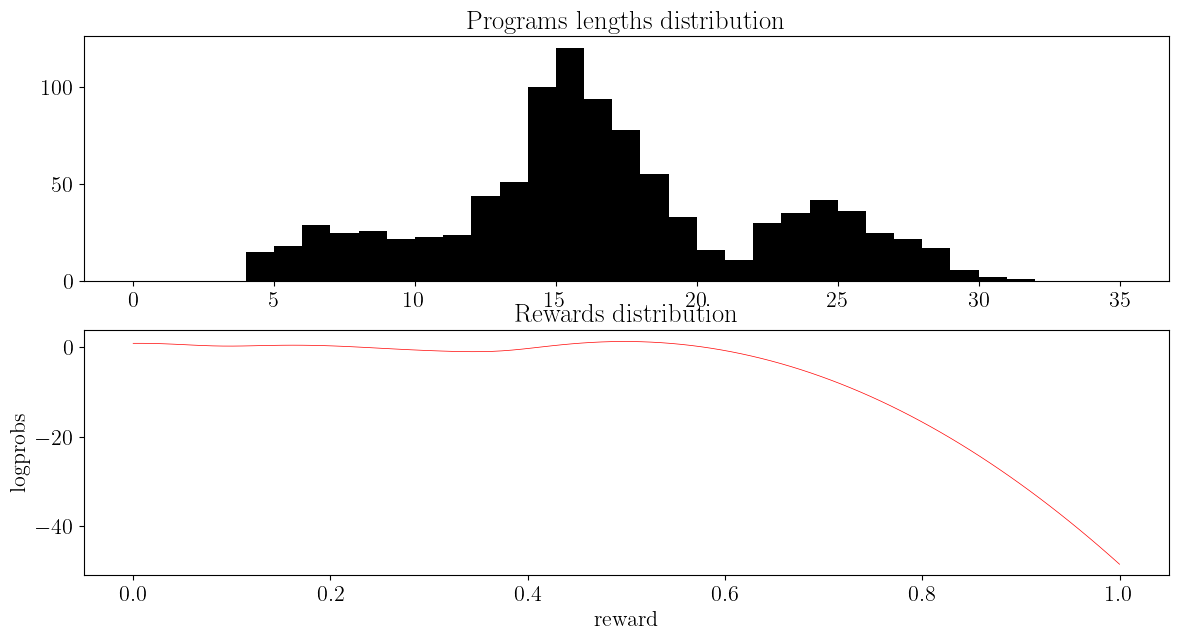

In [17]:
benchmark.dummy_epoch(X, y, run_config)

## Run

=========== Epoch 00000 ===========
-> Time 7.29 s

Overall best  at R=0.514255
-> Raw expression : 
        ⎛            0.5⎞
        ⎜⎛       φ  ⎞   ⎟
        ⎜⎜α₀ + ─────⎟   ⎟
        ⎜⎜     t + t⎟   ⎟
 φ + cos⎜⎜──────────⎟   ⎟
        ⎝⎝    f     ⎠   ⎠
ℯ                        

Best of epoch at R=0.514255
-> Raw expression : 
        ⎛            0.5⎞
        ⎜⎛       φ  ⎞   ⎟
        ⎜⎜α₀ + ─────⎟   ⎟
        ⎜⎜     t + t⎟   ⎟
 φ + cos⎜⎜──────────⎟   ⎟
        ⎝⎝    f     ⎠   ⎠
ℯ                        


=========== Epoch 00001 ===========
-> Time 5.14 s

Overall best  at R=0.525934
-> Raw expression : 
    ⎛                       2⎞
    ⎜⎛        ⎛   ⎛     1⎞⎞⎞ ⎟
    ⎜⎜-φ + log⎜-t⋅⎜-f + ─⎟⎟⎟ ⎟
    ⎝⎝        ⎝   ⎝     t⎠⎠⎠ ⎠
α₀⋅ℯ                          
──────────────────────────────
              f               

Best of epoch at R=0.525934
-> Raw expression : 
    ⎛                       2⎞
    ⎜⎛        ⎛   ⎛     1⎞⎞⎞ ⎟
    ⎜⎜-φ + log⎜-t⋅⎜-f + ─⎟⎟⎟ ⎟
    ⎝⎝        ⎝   ⎝   

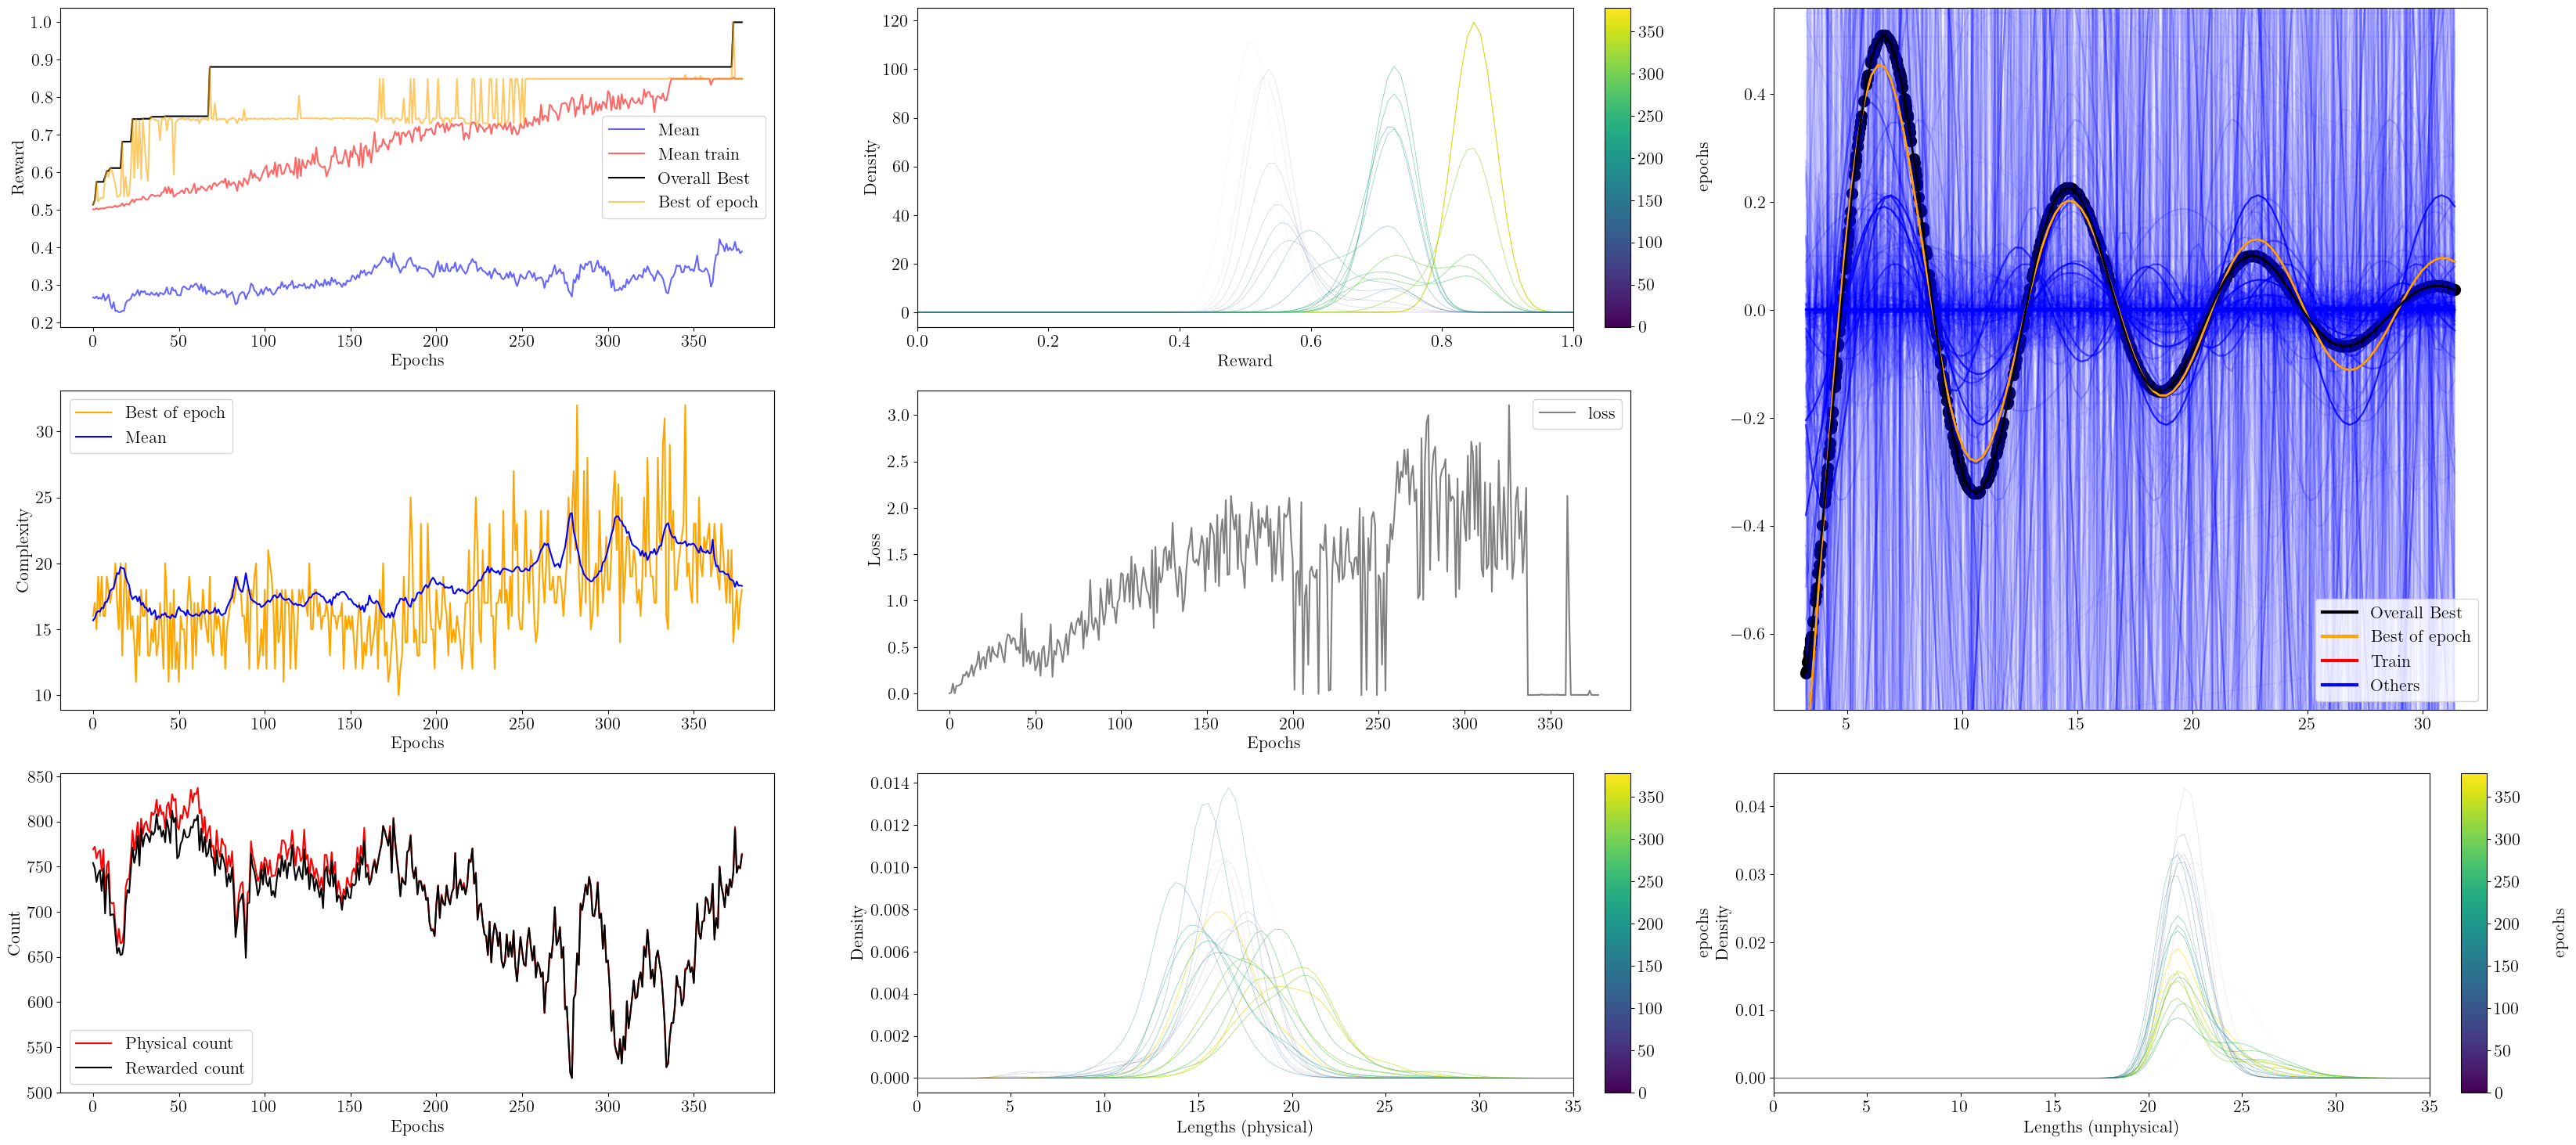

In [18]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999, 
                                stop_after_n_epochs = 5)

## Results

### Run plot

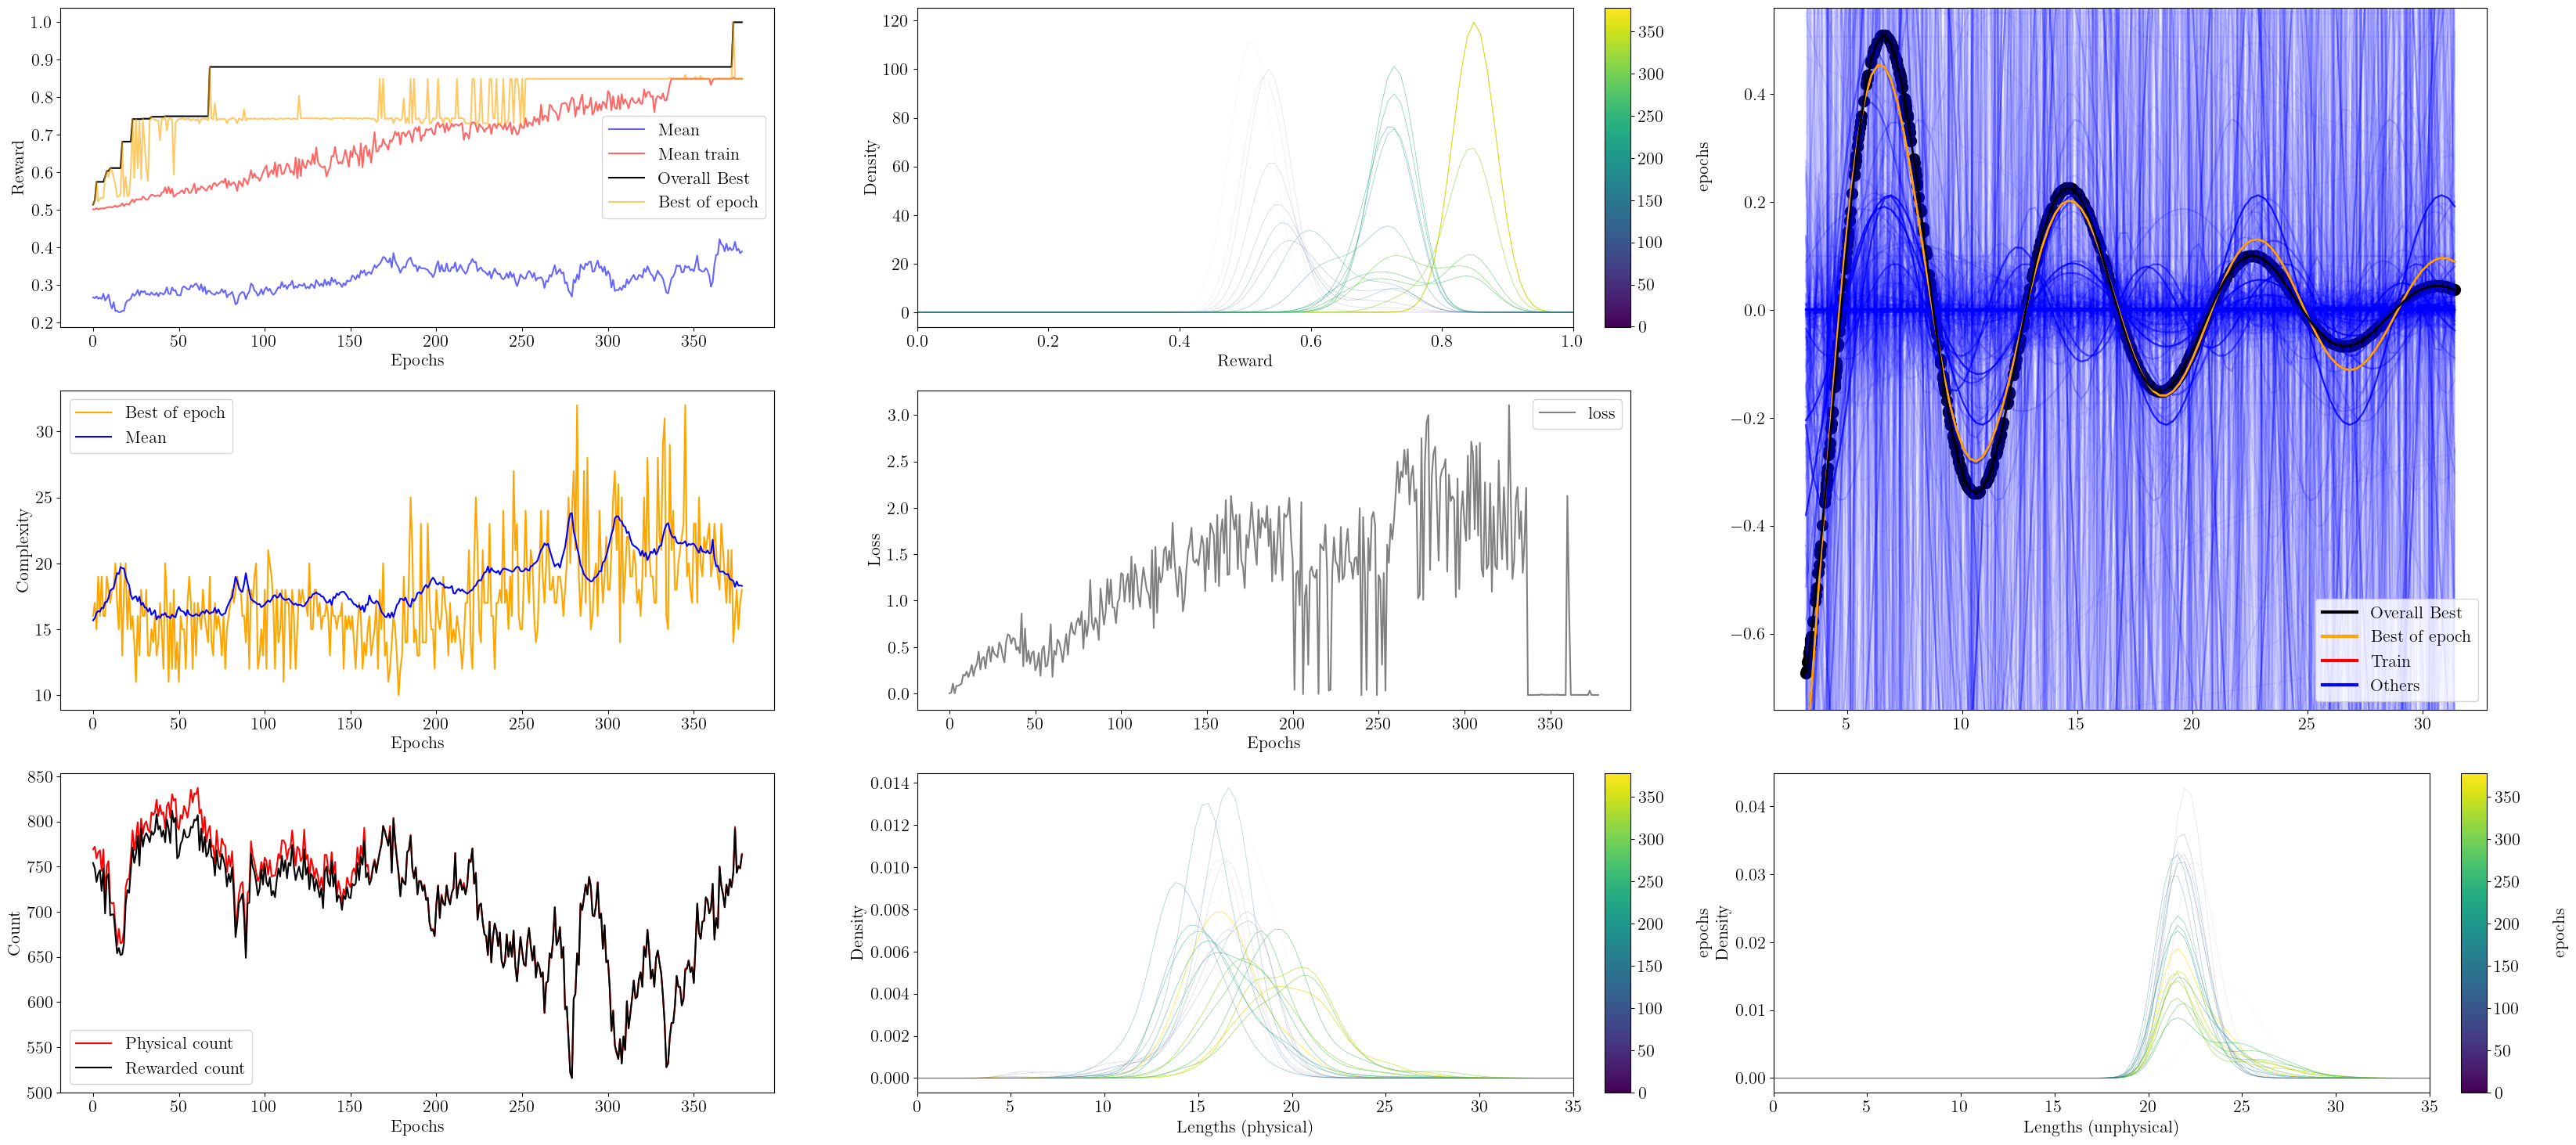

In [19]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [20]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

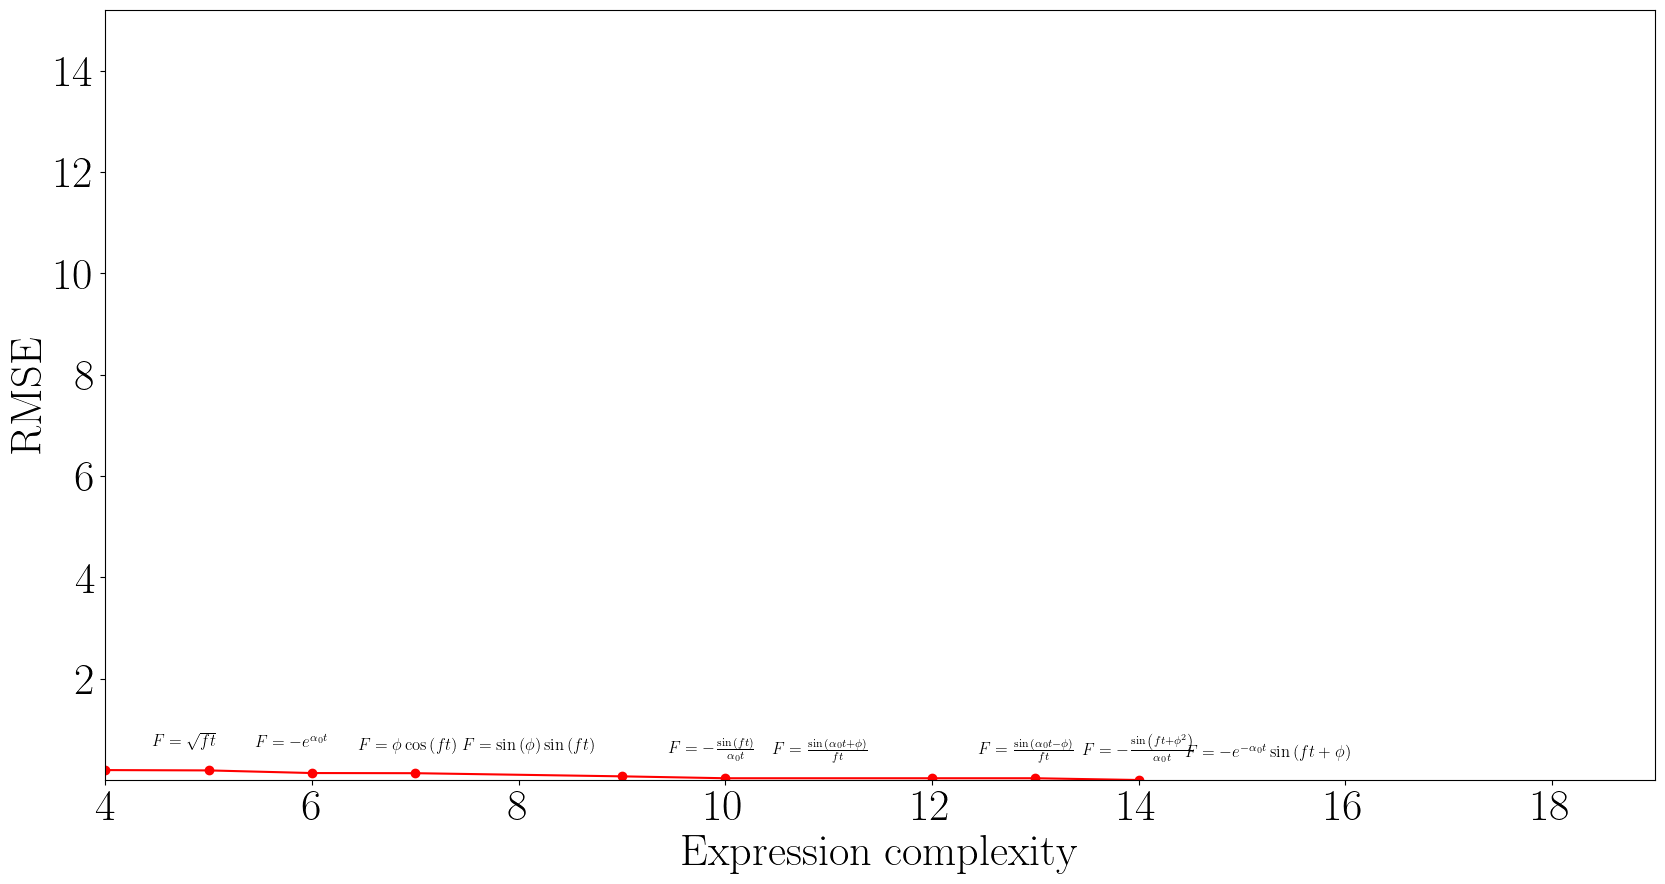

In [21]:
plot_pareto_front(run_logger)


### Complexity - accuracy optimums

In [22]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


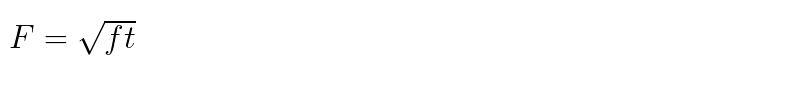

alpha0 = 0.100000
f = 0.000000
phi = 1.000000


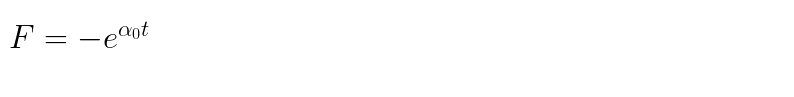

alpha0 = -0.548808
f = 1.000000
phi = 1.000000


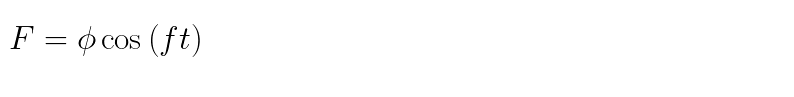

alpha0 = 0.100000
f = 0.851373
phi = 0.195415


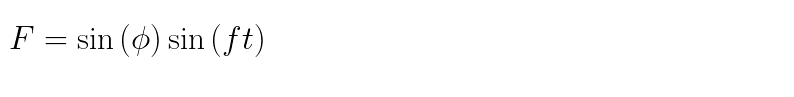

alpha0 = 0.100000
f = 0.743263
phi = -0.208318


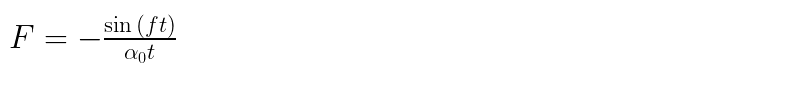

alpha0 = 0.329132
f = 0.731936
phi = 1.000000


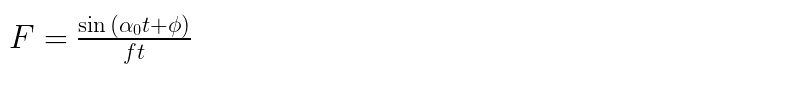

alpha0 = 0.777265
f = 0.334329
phi = 2.655510


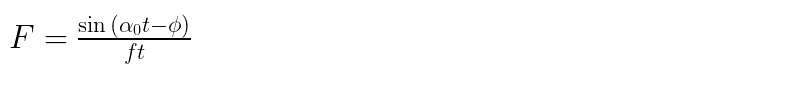

alpha0 = 0.777266
f = 0.334335
phi = 3.627685


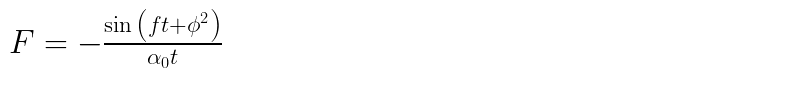

alpha0 = 0.334333
f = 0.777265
phi = 2.407717


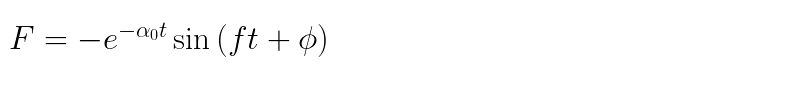

alpha0 = 0.101111
f = 0.783989
phi = 5.709456


In [23]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))